# Exam #2 Retake - FDS FALL 19' - EDA, Statistics and Preprocessing

For this part, you will work with a census data set. Please find the data file and the data dictionary attached.

<div class="alert alert-warning">
<b>Important:</b> Make sure you follow what we learned regarding what should be done on the train set and what should be done on the test set
</div>

<div class="alert alert-info">
<b>Note:</b> You should submit the answers to this question in a report format - everything you do should be documented, you should track the changes to the shape of your dataset, explain the business thought behind your decisions and make everything super clear
</div>

<div class="alert alert-warning">
<b>Important:</b> Do not perform actions that are not neccessary. Make sure there is a thought behind each step you take
</div>

**Here are some packages you will need:**

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

**Here are some helper functions for your use:**

In [2]:
def get_redundant_binary_cols(data, threshold):
    '''
    This function gets a pandas DataFrame, and a threshold (% of data), 
    and returns the list of binary features from that dataframe that have 
    above threshold amount of samples with the same value, and thus
    should be considered redundant. 
    '''
    
    bool_cols = [col for col in data \
             if pd.Series(data[col].unique()).isin([0, 1]).all()]
    return [x for x in bool_cols if data[x].value_counts()[0] \
                                                > threshold * len(X_train)] + \
                    [x for x in bool_cols if data[x].value_counts()[1] \
                                                > threshold * len(X_train)]

`pd.to_datetime(df.Date)`: will transfer a string column to a date type

**Questions:**

1. Read the data file and present summary statistics, datatype per column and NA status for each column. 

1.b. Perform data integrity checks if needed (Don't do more than two columns)

In [55]:
df = pd.read_csv("adult_data.csv")
df.head()

,Unnamed: 0,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [56]:
df.shape

(32561, 16)

In [57]:
df.columns

Index(['Unnamed: 0', 'age', 'workclass', 'fnlwgt', 'education',
       'education-num', 'marital-status', 'occupation', 'relationship', 'race',
       'sex', 'capital-gain', 'capital-loss', 'hours-per-week',
       'native-country', 'income'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 16 columns):
Unnamed: 0        32561 non-null int64
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    32561 non-null object
income            32561 non-null object
dtypes: int64(7), object(9)
memory usage: 4.0+ MB


We can see there are non NAN's in our data, which is great

In [58]:
df.isna().sum()

Unnamed: 0        0
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [8]:
df.describe()

,Unnamed: 0,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,16280.000000,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,9399.695394,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,0.000000,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,8140.000000,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,16280.000000,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,24420.000000,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,32560.000000,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


We can see that the capital_gain columns on one hand has ~1077 as the mean, but zero as the median which raises a flag that 
there may be many zeros in this set which are not related to the actual data. Same thing for capital loss. Lets use a bubble-plot to gain more information.

In [9]:
from bubble_plot.utils import describe_categorical_values

describe_categorical_values(df)

,0,1,2,3,4
Unnamed: 0,2047: 0%,32069: 0%,5416: 0%,7465: 0%,1322: 0%
age,36: 3%,31: 3%,34: 3%,23: 3%,35: 3%
workclass,Private: 70%,Self-emp-not-inc: 8%,Local-gov: 6%,?: 6%,State-gov: 4%
fnlwgt,164190: 0%,203488: 0%,123011: 0%,113364: 0%,121124: 0%
education,HS-grad: 32%,Some-college: 22%,Bachelors: 16%,Masters: 5%,Assoc-voc: 4%
education-num,9: 32%,10: 22%,13: 16%,14: 5%,11: 4%
marital-status,Married-civ-spouse: 46%,Never-married: 33%,Divorced: 14%,Separated: 3%,Widowed: 3%
occupation,Prof-specialty: 13%,Craft-repair: 13%,Exec-managerial: 12%,Adm-clerical: 12%,Sales: 11%
relationship,Husband: 41%,Not-in-family: 26%,Own-child: 16%,Unmarried: 11%,Wife: 5%
race,White: 85%,Black: 10%,Asian-Pac-Islander: 3%,Amer-Indian-Eskimo: 1%,Other: 1%


Indeed 92% of our capital-gain feature and 95% of our capital-loss are zeros. We will definitely consider removing these columns in the upcoming sections. The Unamed: 0 and fnlwgt columns seem to present no information as the values are different for each column (as an index). We will therefore remove them. We can also see there are no duplicate rows in our data.

In [10]:
df[df.duplicated()]

,Unnamed: 0,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income


In [11]:
df.drop(['Unnamed: 0','fnlwgt'], axis=1,inplace=True)

2. We are trying to Predict whether income exceeds $50K/yr, per row in the data (person). According to this research question, define the dependent variable, as well as all the categorical (nominal / ordinal) and continuous features, in a markdown cell

In [12]:
num_vars = set(df._get_numeric_data().columns)
num_vars

{'age', 'capital-gain', 'capital-loss', 'education-num', 'hours-per-week'}

In [13]:
cat_vars = set(df.columns) - num_vars-{'income'}
cat_vars

{'education',
 'marital-status',
 'native-country',
 'occupation',
 'race',
 'relationship',
 'sex',
 'workclass'}

In [14]:
target='income'

**our research question:**  Predicting whether a person will earn an income of over $50K/yr. Therefore our dependent variable is the income which is a categorical feature

**Categorical Features:**

Nominal- workclass,marital-status,occupation,relationship,race,native-country,sex

Ordinal- education , (also Unnamed: 0 and  fnlwgt which we removed and we assume it is some kind of index)

**Numerical Features:**
age, education-num,capital-gain,capital-loss,hours-per-week

In [15]:
df.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


3. Plot the distribution (density plot / histogram) per feature. Make sure you use the correct plot per type of feature, and that you do not plot categorical features with unique values only.

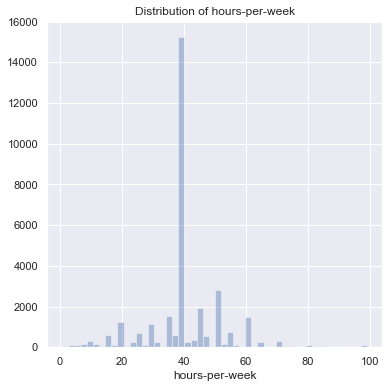

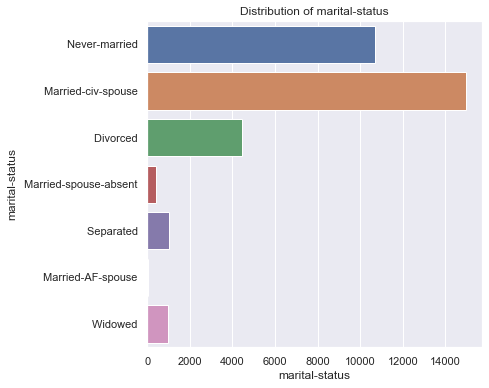

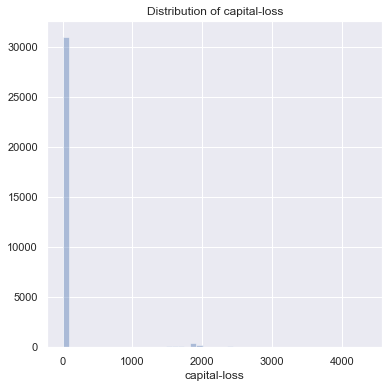

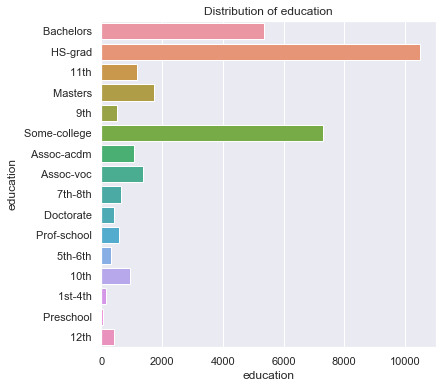

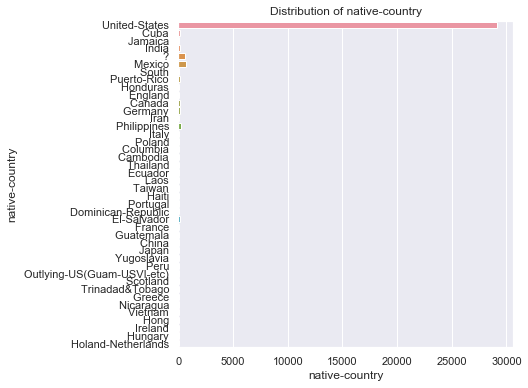

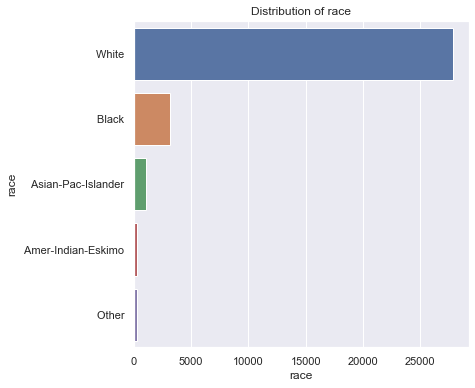

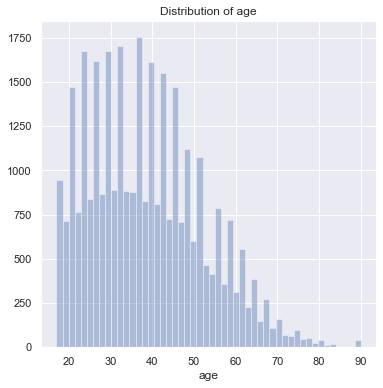

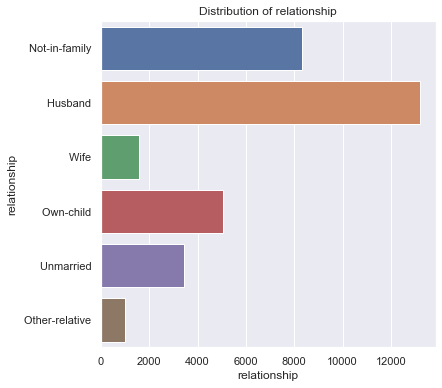

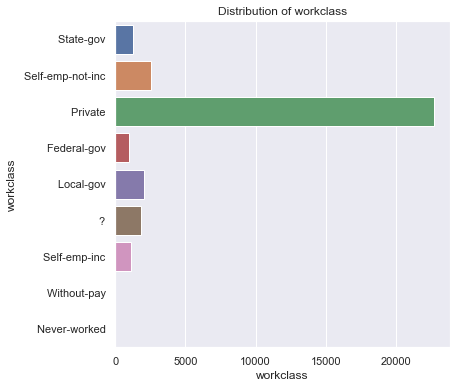

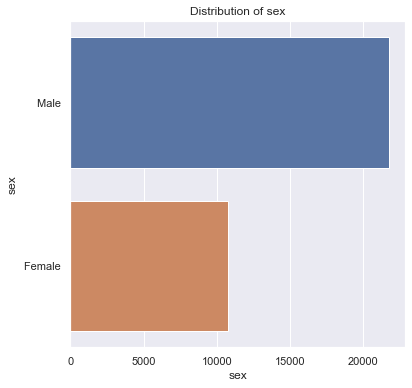

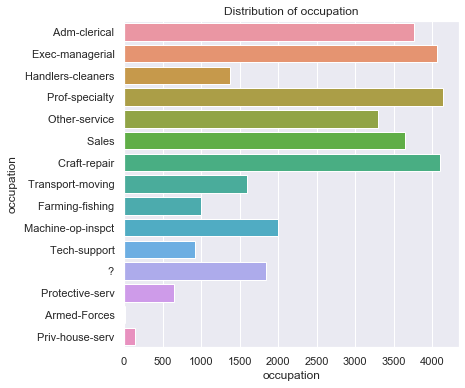

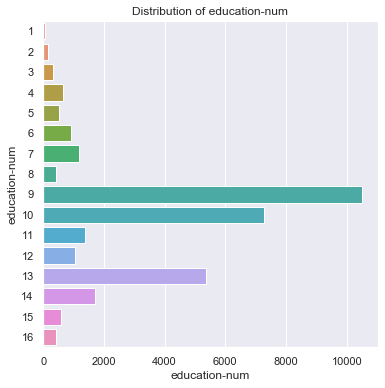

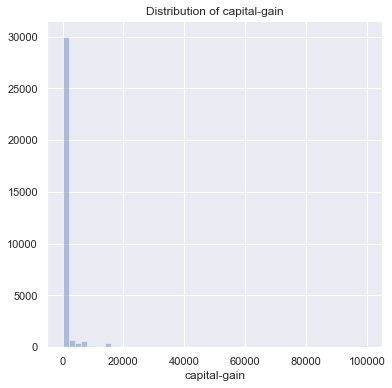

In [16]:
sns.set(style="darkgrid")
discrete_features = {'education','marital-status','native-country','occupation','race','relationship','sex','workclass'\
                     ,'education-num'}
continuous_features = {'capital-gain', 'capital-loss','hours-per-week','age'}
variables=continuous_features.union(discrete_features)
for variable in variables:
    plt.figure(figsize=(6,6))
    if variable in continuous_features:
        sns.distplot(df[variable].dropna(),kde=False)
    elif variable in discrete_features: 
        sns.countplot(y=variable, data=df)       
    plt.title(f'Distribution of {variable}')
    plt.xlabel(variable)
    plt.show()

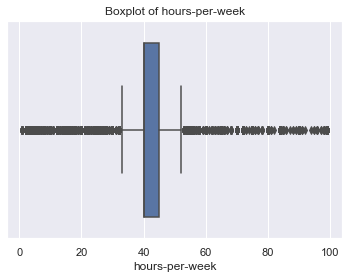

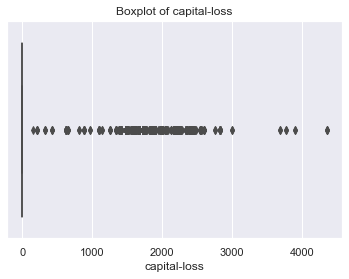

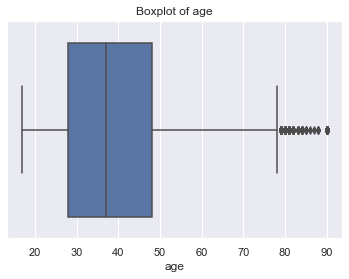

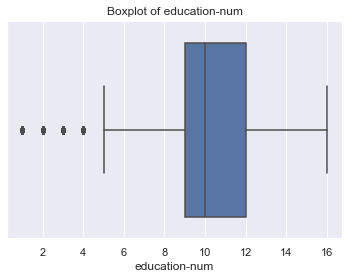

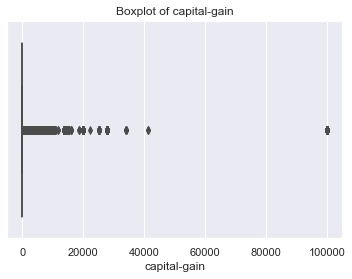

In [17]:
for variable in num_vars:
    ax = sns.boxplot(x=df[variable])
    plt.title(f'Boxplot of {variable}')
    plt.xlabel(variable)
    plt.show()

4. Split the data to a train set and a test set according to a method of your choice, and specify your business logic behind this choice 

We will use a random split to split our data, in order to maintain the same distribution of our features among the sets.

In [18]:
from sklearn.model_selection import train_test_split
X = df[cat_vars.union(num_vars)]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
set(X_train.index) & set(X_test.index)


In [19]:
# Integrity checks
(X_train.shape[0] / len(df), X_test.shape[0] / len(df))

(0.7999754307300144, 0.20002456926998557)

In [20]:
y_train.reset_index(drop=True,inplace=True)
X_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


## **Take the next steps on <span style="color:red">both datasets</span>, according to the restrictions you learned.**

5. Take care of NA values and outliers (if any). Specify the business logic behind your choice.

We said before that there aren't any NA values, but many zeros in the capital-loss and capital-gain columns which we will treat
as NA values. We will remove the capital-loss and capital-gain columns since more than 90% of their values are zeros.

In addition the work-class and occupation features have questionmarks (?) values in a large percentage of the data, we will replace them with 'other' so we do not loose data

In [21]:
len(df[df['capital-loss'] == 0])/len(df)

0.9533490986149074

In [22]:
len(df[df['capital-gain'] == 0])/len(df)

0.9167101747489328

In [23]:
X_train.drop(columns=['capital-gain'],inplace=True)
X_train.drop(columns=['capital-loss'],inplace=True)

In [24]:
X_test.drop(columns=['capital-gain'],inplace=True)
X_test.drop(columns=['capital-loss'],inplace=True)

In [25]:
X_train['workclass'].value_counts()/len(X_train)

 Private             0.695562
 Self-emp-not-inc    0.078432
 Local-gov           0.065494
 ?                   0.055551
 State-gov           0.040080
 Self-emp-inc        0.034705
 Federal-gov         0.029522
 Without-pay         0.000384
 Never-worked        0.000269
Name: workclass, dtype: float64

In [26]:
X_train['occupation'].value_counts()/len(X_train)

 Prof-specialty       0.127150
 Craft-repair         0.125845
 Exec-managerial      0.123925
 Adm-clerical         0.116861
 Sales                0.112139
 Other-service        0.100891
 Machine-op-inspct    0.062346
 ?                    0.055820
 Transport-moving     0.049140
 Handlers-cleaners    0.042115
 Farming-fishing      0.030751
 Tech-support         0.028371
 Protective-serv      0.019694
 Priv-house-serv      0.004722
 Armed-Forces         0.000230
Name: occupation, dtype: float64

In [27]:
X_train['occupation'][X_train['occupation']==' ?']='Other'
X_test['occupation'][X_test['occupation']==' ?']='Other'

In [28]:
X_train['workclass'][X_train['workclass']==' ?']='Other'
X_test['workclass'][X_test['workclass']==' ?']='Other'

We can also see that for the native-country feature, about 90% of the values are 'United States', and there is one sub-category which is a questionmark. 
We will therefore put all 'United States' in 1 bin, and all other states in a 'Other' sub-category

In [29]:
X_train['native-country'].value_counts()/len(X_train)

 United-States                 0.894502
 Mexico                        0.020309
 ?                             0.017583
 Philippines                   0.006258
 Germany                       0.004031
 Canada                        0.003801
 Puerto-Rico                   0.003532
 El-Salvador                   0.003302
 India                         0.003033
 England                       0.002918
 Cuba                          0.002918
 Jamaica                       0.002611
 South                         0.002572
 Dominican-Republic            0.002380
 Vietnam                       0.002380
 Italy                         0.002265
 China                         0.002188
 Columbia                      0.002035
 Guatemala                     0.001958
 Japan                         0.001958
 Poland                        0.001766
 Taiwan                        0.001536
 Haiti                         0.001459
 Iran                          0.001190
 Portugal                      0.001190


In [30]:
X_train['native-country']=(X_train['native-country']==' United-States').astype(int)
X_test['native-country']=(X_test['native-country']==' United-States').astype(int)

In [31]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((26048, 11), (26048,), (6513, 11), (6513,))

I addition we will remove rows which contain sub-categorical values containing less than 0.5% of the total category

In [32]:
threshold=0.005
for param in cat_vars:
    keep_values_set=set(X_train[param].value_counts()[(X_train[param].value_counts()/len(X_train)>threshold)].index)
    y_train=y_train[X_train[param].isin(keep_values_set).values]
    X_train=X_train.iloc[X_train[param].isin(keep_values_set).values]
    y_test=y_test[X_test[param].isin(keep_values_set).values]
    X_test=X_test.iloc[X_test[param].isin(keep_values_set).values]
    y_train.reset_index(drop=True,inplace=True)
    X_train.reset_index(drop=True,inplace=True)
    y_test.reset_index(drop=True,inplace=True)
    X_test.reset_index(drop=True,inplace=True)

In [33]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((25843, 11), (25843,), (6467, 11), (6467,))

We will remove outliers for the numeric parameters as well, according to the IQR

In [34]:
def remove_outlier(df_in, col_name,y,df_test,y_test):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    y=y.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    y_test=y_test.loc[(df_test[col_name] > fence_low) & (df_test[col_name] < fence_high)]
    df_test= df_test.loc[(df_test[col_name] > fence_low) & (df_test[col_name] < fence_high)]
    df_out.reset_index(drop=True,inplace=True)
    y.reset_index(drop=True,inplace=True)
    df_test.reset_index(drop=True,inplace=True)
    y_test.reset_index(drop=True,inplace=True)
    return df_out, y,df_test,y_test

In [35]:
for param in ['age','education-num']:
    X_train, y_train,X_test, y_test=remove_outlier(X_train,'education-num',y_train,X_test,y_test)

In [36]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((24950, 11), (24950,), (6248, 11), (6248,))

6. Plot the distribution of 3 variables of your choice against the dependent variable - summarize interesting findings if any. One of the chosen features must be numeric, and another one must be categorical. You can choose the third one as you wish.

<Figure size 432x288 with 0 Axes>

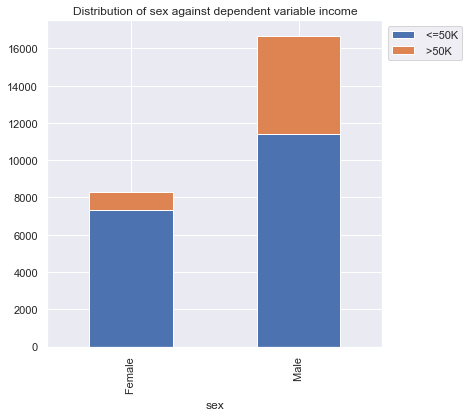

<Figure size 432x288 with 0 Axes>

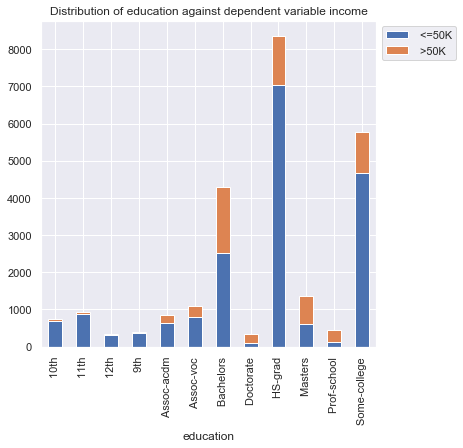

In [37]:
df_train=X_train.copy()
df_train[target]=y_train
cat_vars={'sex','education'}

for feature in cat_vars:
    plt.figure()
    ax = df_train.groupby([target, feature]).size().reset_index().pivot(columns=target, 
                                                                        index=feature, 
                                                                        values=0)
    ax.plot(kind='bar', stacked=True, figsize=(6,6))
    plt.legend(loc='upper left', bbox_to_anchor= (1, 1))
    plt.title('Distribution of {} against dependent variable {}'.format(feature, target))
    plt.show()

We can see that in general, men and people with higher education in our data have higher income

In [38]:
def display_group_density_plot(df, groupby, on, palette, figsize):
    """
    Displays a density plot by group, given a continuous variable, and a group to split the data by
    :param df: DataFrame to display data from
    :param groupby: Column name by which plots would be grouped (Categorical, maximum 10 categories)
    :param on: Column name of the different density plots
    :param palette: Color palette to use for drawing
    :param figsize: Figure size
    :return: matplotlib.axes._subplots.AxesSubplot object
    """

    if not isinstance(df, pd.core.frame.DataFrame):
        raise ValueError('df must be a pandas DataFrame')

    if not groupby:
        raise ValueError('groupby parameter must be provided')

    elif not groupby in df.keys():
        raise ValueError(groupby + ' column does not exist in the given DataFrame')

    if not on:
        raise ValueError('on parameter must be provided')

    elif not on in df.keys():
        raise ValueError(on + ' column does not exist in the given DataFrame')

    if len(set(df[groupby])) > 10:
        groups = df[groupby].value_counts().index[:10]

    else:
        groups = set(df[groupby])

    # Get relevant palette
    if palette:
        palette = palette[:len(groups)]
    else:
        palette = sns.color_palette()[:len(groups)]

    # Plot
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')

    for value, color in zip(groups, palette):
        sns.kdeplot(df.loc[df[groupby] == value][on], \
                    shade=True, color=color, label=value)

    ax.set_title(str("Distribution of " + on + " per " + groupby + " group"),\
                 fontsize=30)
    
    ax.set_xlabel(on, fontsize=20)
    return ax 

No handles with labels found to put in legend.


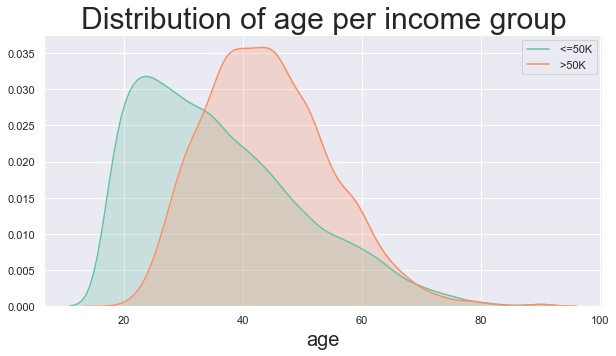

In [39]:
display_group_density_plot(df_train, groupby = "income", on = 'age', \
                                           palette = sns.color_palette('Set2'), 
                           figsize = (10, 5));

We can see that we can clearly differentiate between the two distributions therefore the age feature may contribute to our model. In certain ages, up to ~35 years, the average income is relatively lower than about 35 years.

7. Plot the distribution of 3 independent variables against eachother (3 plots overall), including a color bar for the dependent variable - summarize interesting findings if any. One of the chosen features must be numeric, and another one must be categorical. You can choose the third one as you wish.

In [40]:
df['income'][32557]

' >50K'

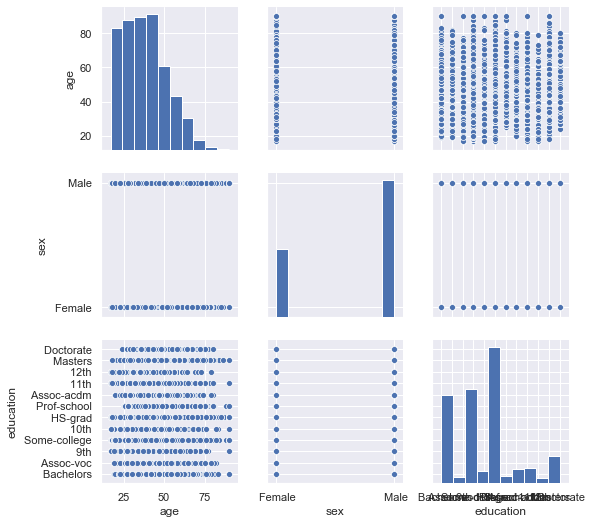

In [41]:

import numpy as np
np.seterr(divide='ignore', invalid='ignore')

sns.pairplot(df_train.dropna(), vars=["age","sex",'education'], height=2.5);

9. Generate a correlation matrix and plot a heat map of it. What can you say about the correlations?

In [42]:
df_train=X_train.copy()
df_train[target]=y_train
df_train['income']=(df_train['income']==' >50K').astype(int)
def color_map(val):
    color = 'red' if float(val) < -0.4 else 'green' if float(val) > 0.4  else 'black'
    return 'color: %s' % color

corr = df_train.corr()
df_styled = corr.style.applymap(color_map)
df_styled

,hours-per-week,education-num,native-country,age,income
hours-per-week,1,0.159583,0.00108058,0.0920903,0.231441
education-num,0.159583,1,-0.0269404,0.113221,0.340235
native-country,0.00108058,-0.0269404,1,0.015327,0.0169913
age,0.0920903,0.113221,0.015327,1,0.255422
income,0.231441,0.340235,0.0169913,0.255422,1


<Figure size 432x288 with 0 Axes>

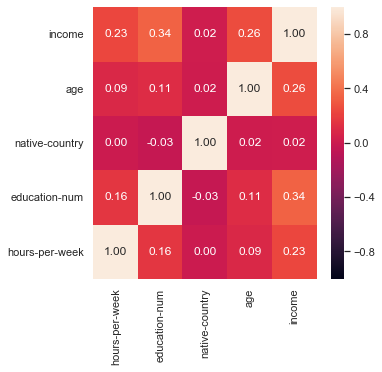

In [43]:
plt.figure()
plt.figure(figsize=(5, 5))
y_train=df_train['income']
sns.heatmap(pd.concat([X_train, y_train], axis =1).corr(), annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.xlim(0,5)
plt.ylim(0,5);

We can see the education feature has the highest correlation to the income

In [44]:
X_train.columns

Index(['hours-per-week', 'education-num', 'education', 'native-country',
       'race', 'age', 'workclass', 'relationship', 'sex', 'occupation',
       'marital-status'],
      dtype='object')

11. Deal with 3 of the categorical features (prepare them for a model)

In [45]:
X_train = pd.get_dummies(X_train, columns=["relationship","native-country","workclass"]).copy()

In [46]:
X_test = pd.get_dummies(X_test, columns=["relationship","native-country","workclass"]).copy()

12. Deal with numerical features

In [47]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm_scaler = MinMaxScaler()
print(mm_scaler.fit(X_train._get_numeric_data()))
X_train[X_train._get_numeric_data().columns.values]=mm_scaler.transform(X_train._get_numeric_data())
X_test[X_test._get_numeric_data().columns.values]=mm_scaler.transform(X_test._get_numeric_data())

MinMaxScaler(copy=True, feature_range=(0, 1))


In [48]:
X_train.head()

,hours-per-week,education-num,education,race,age,sex,occupation,marital-status,relationship_ Husband,relationship_ Not-in-family,...,relationship_ Wife,native-country_0,native-country_1,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_Other
0,0.500000,0.727273,Bachelors,White,0.219178,Female,Prof-specialty,Never-married,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.500000,0.545455,Assoc-voc,White,0.260274,Male,Exec-managerial,Married-civ-spouse,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.397959,0.000000,9th,White,0.561644,Male,Craft-repair,Separated,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.459184,0.545455,Assoc-voc,White,0.054795,Male,Farming-fishing,Married-civ-spouse,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.397959,0.454545,Some-college,White,0.136986,Male,Other-service,Divorced,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


13. Select features according to the correlations and other criteria (cardinality, value distribution, % of similar values in the column, drop ids, etc...) - see helper function. By selecting features we mean - drop any unwanted features. **Make sure you are left only with features that we can you in a model**

I will first remove columns which are redundant, meaning have low cardinality

In [49]:
redundant_cols=get_redundant_binary_cols(X_train, 0.9)
redundant_cols

['relationship_ Other-relative',
 'relationship_ Wife',
 'native-country_0',
 'workclass_ Federal-gov',
 'workclass_ Local-gov',
 'workclass_ Self-emp-inc',
 'workclass_ Self-emp-not-inc',
 'workclass_ State-gov',
 'workclass_Other',
 'native-country_1']

In [50]:
X_train.drop(redundant_cols, axis=1,inplace=True)
X_test.drop(redundant_cols, axis=1,inplace=True)

In [51]:
df_train=X_train
df_train['income']=y_train
corr = df_train.corr()
df_styled = corr.style.applymap(color_map)
df_styled

,hours-per-week,education-num,age,relationship_ Husband,relationship_ Not-in-family,relationship_ Own-child,relationship_ Unmarried,workclass_ Private,income
hours-per-week,1,0.159583,0.0920903,0.255193,0.00621039,-0.262213,-0.030535,-0.0239374,0.231441
education-num,0.159583,1,0.113221,0.106951,0.0606203,-0.149758,-0.0645874,-0.132274,0.340235
age,0.0920903,0.113221,1,0.325386,-0.00845492,-0.441828,0.0405417,-0.202469,0.255422
relationship_ Husband,0.255193,0.106951,0.325386,1,-0.482987,-0.359667,-0.282749,-0.0812983,0.410527
relationship_ Not-in-family,0.00621039,0.0606203,-0.00845492,-0.482987,1,-0.253424,-0.199227,0.0309412,-0.194613
relationship_ Own-child,-0.262213,-0.149758,-0.441828,-0.359667,-0.253424,1,-0.148359,0.0667959,-0.237391
relationship_ Unmarried,-0.030535,-0.0645874,0.0405417,-0.282749,-0.199227,-0.148359,1,0.0131264,-0.144461
workclass_ Private,-0.0239374,-0.132274,-0.202469,-0.0812983,0.0309412,0.0667959,0.0131264,1,-0.0763278
income,0.231441,0.340235,0.255422,0.410527,-0.194613,-0.237391,-0.144461,-0.0763278,1


By the correlation matrix we can see the education_num and relationship_husband have the highest correlation to the income.
We can also see some features are correlated as relationship_own_child and age, which makes sense.
I would consider removing the workclass_private feature which as very low low correlation to the income.

In [52]:
redundant_cols=['workclass_ Private','relationship_ Husband']
X_train.drop(redundant_cols, axis=1,inplace=True)
X_test.drop(redundant_cols, axis=1,inplace=True)
X_train.drop(['income'], axis=1,inplace=True)

In [53]:
X_train.columns

Index(['hours-per-week', 'education-num', 'education', 'race', 'age', 'sex',
       'occupation', 'marital-status', 'relationship_ Not-in-family',
       'relationship_ Own-child', 'relationship_ Unmarried'],
      dtype='object')

In [54]:
X_test.columns

Index(['hours-per-week', 'education-num', 'education', 'race', 'age', 'sex',
       'occupation', 'marital-status', 'relationship_ Not-in-family',
       'relationship_ Own-child', 'relationship_ Unmarried'],
      dtype='object')